### Проект: вариант 2

Импортируем нужные библиотеки для работы с файлами:

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta

import requests
import json
from urllib.parse import urlencode

import pandahouse as ph

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats as ss
from scipy.stats import bootstrap
from scipy.stats import chi2_contingency, levene

import warnings
warnings.filterwarnings('ignore')

### Задание 1. A/B–тестирование
### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

В качестве входных данных были использованы файлы с Яндекс.Диска, поэтому используем библиотеки requests, urllib.parse и формат json для создания ссылок на файлы и дальнейшего преобразования их пандасовский датафрейм

Используем API и публичные ключи(поскольку ссылки на файлы открытые)

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

In [3]:
public_key_for_groups='https://disk.yandex.ru/d/UhyYx41rTt3clQ'
public_key_for_group_add='https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
public_key_for_active_studs='https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
public_key_for_checks='https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

In [4]:
# Получаем загрузочную ссылку

In [5]:
final_url_for_groups=base_url + urlencode(dict(public_key=public_key_for_groups))
final_url_for_group_add=base_url + urlencode(dict(public_key=public_key_for_group_add))
final_url_for_active_studs=base_url + urlencode(dict(public_key=public_key_for_active_studs))
final_url_for_checks=base_url + urlencode(dict(public_key=public_key_for_checks))

In [6]:
group_response=requests.get(final_url_for_groups)
group_add_response=requests.get(final_url_for_group_add)
active_studs_response=requests.get(final_url_for_active_studs)
checks_response=requests.get(final_url_for_checks)
print(group_response)
print(group_add_response)
print(active_studs_response)
print(checks_response)
#response<300, значит, все сработало корректно и без ошибок, ссылки создались

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


In [7]:
download_url_for_groups        = group_response.json()['href']
download_url_for_for_group_add = group_add_response.json()['href']
download_url_for_active_studs  = active_studs_response.json()['href']
download_url_for_checks        = checks_response.json()['href']

In [8]:
# загружаем файлы в df
groups=pd.read_csv(download_url_for_groups,sep=';')
added_group=pd.read_csv(download_url_for_for_group_add)
active_studs=pd.read_csv(download_url_for_active_studs)
checks=pd.read_csv(download_url_for_checks, sep=';')

### Проведем разведочный анализ данных(EDA, exploratory data analysis)

In [9]:
groups.dtypes

id      int64
grp    object
dtype: object

In [10]:
added_group.dtypes

id      int64
grp    object
dtype: object

In [11]:
active_studs.dtypes

student_id    int64
dtype: object

In [12]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [13]:
groups.shape

(74484, 2)

In [14]:
added_group.shape

(92, 2)

In [15]:
active_studs.shape

(8341, 1)

In [16]:
checks.shape

(541, 2)

In [17]:
#Типы данных совпадают, количество столбцов и строк разное, учитывая что в них записано, это нормально

Проверяем пропущенные значения в датафреймах через df.isna().sum(), где df-наши датафреймы

In [18]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [19]:
added_group.isna().sum()

id     0
grp    0
dtype: int64

In [20]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [21]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [22]:
groups.loc[groups.duplicated()] 

,id,grp


In [23]:
added_group.loc[added_group.duplicated()] 

,id,grp


In [24]:
active_studs.loc[active_studs.duplicated()] 

,student_id


In [25]:
checks.loc[checks.duplicated()] 

,student_id,rev


In [26]:
#дубликатов в датафреймах нет, пропущенные значения отсутствуют

In [27]:
#посмотрим на данные в датафреймах

In [28]:
groups.head(3)
#группе (А – контроль, B – эксперимент)

,id,grp
0,1489,B
1,1627,A
2,1768,B


In [29]:
added_group.head(3)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B


In [30]:
active_studs.head(3)

,student_id
0,581585
1,5723133
2,3276743


In [31]:
checks.head(3)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


In [32]:
#объединим датафреймы groups и added_group
full_group=pd.concat([groups, added_group], ignore_index=True)

In [33]:
full_group.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


In [34]:
#посмотрим на количество 
df=full_group.groupby('grp').agg({'id': 'count'}).reset_index()
#группе (А – контроль, B – эксперимент)
df.head()

,grp,id
0,A,14693
1,B,59883


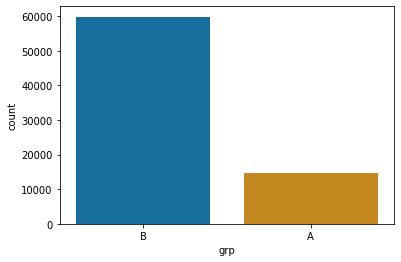

In [35]:
sns.countplot(data=full_group, x='grp',palette="colorblind")

В группе "B", то есть в эксперементальной группе, чуть больше чем в 4 раза, чем в контрольной группе "A",  что может говорить о том, что продуктовая команда решила на большее число клиентов развернуть новую механику оплаты услуг на сайте, в любом случае, количество данных для A/B анализа достаточно, слишком большого перевеса нет.

In [36]:
full_group_copy=full_group.copy(deep=True)

In [37]:
# Поскольку нам важны не все-все юзеры, а данные по студентам, которые участововали в дни A-B теста, используем левый джойн.

In [38]:
users_on_testing      =active_studs.merge(full_group_copy, left_on='student_id', right_on='id', how='left')
users_on_testing_days = users_on_testing.drop('id', axis=1)

Поскольку рассматривать конверсию перехода на сайт в дни тестирования по группам не имеет смысла(т.к. мы тестируем 
гипотезы, больше связанные с технической частью работы продукта), а не маркетинговые гипотезы(нет такой задачи и данных о рекламе), основной целью которых являются конверсии с переходами на сайт/ приложения компании, в качестве основго датафрейма будем использовать users_on_testing_days


In [39]:
#переименуем столбец с названием групп для красоты
users_on_testing_days=users_on_testing_days.rename(columns={'grp':'group'})

In [40]:
users_on_testing_days.head()

,student_id,group
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B


In [41]:
users_on_testing_days.isna().sum()

student_id    0
group         0
dtype: int64

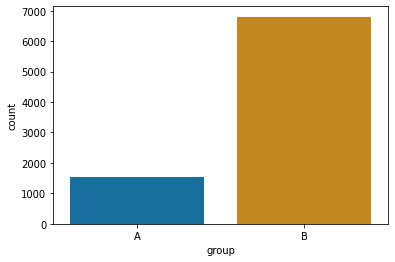

In [42]:
sns.countplot(data=users_on_testing_days, x='group',palette="colorblind")

In [43]:
users_on_testing_days.shape

(8341, 2)

In [44]:
checks.shape

(541, 2)

Объединяем данные с данными студентов, которые были на сайте в период A/B теста с данными об оплатах клиентов во время эксперимента

In [45]:
users_on_testing_with_checks=users_on_testing_days.merge(checks, how='left',on='student_id')

In [46]:
users_on_testing_with_checks.head()

,student_id,group,rev
0,581585,A,NaN
1,5723133,A,NaN
2,3276743,B,NaN
3,4238589,A,NaN
4,4475369,B,NaN


In [47]:
users_and_checks=users_on_testing_with_checks.groupby(['group','student_id']).agg({'rev':'sum'}).reset_index()

Гипотеза 1.Нулевая гипотеза-конверсия в покупку в дни тестирования не отличается в зависимости от выбранной группы(контрольная и тестовая). H1-конверсия в покупку в зависимости от выбранной группы стат.значимо отличается.

In [48]:
#напишем функцию, которая для тех, кто сделал целевое действие(заплатил), ставил 1, а для тех, кто нет, ноль соответственно.

In [49]:
def f(row):
    if row['rev']>0:
        val = 1
    else:
        val = 0
    return val

In [50]:
users_and_checks['is_paid'] = users_and_checks.apply(f, axis=1)

In [51]:
users_and_checks.head()

,group,student_id,rev,is_paid
0,A,1627,990.0,1
1,A,3391,0.0,0
2,A,109623,0.0,0
3,A,133678,0.0,0
4,A,175944,0.0,0


In [52]:
users_and_checks.groupby('group').is_paid.value_counts()

group  is_paid
A      0          1460
       1            78
B      0          6489
       1           314
Name: is_paid, dtype: int64

In [53]:
control_group=users_and_checks.query('group=="A"')

In [54]:
testing_group=users_and_checks.query('group=="B"')

In [55]:
#посмотрим на количество клиентов(оплативших и не оплативших на сайте в течение тестирования)

In [56]:
sum_control_is_paid=control_group['is_paid'].sum()
sum_testing_is_paid=testing_group['is_paid'].sum()

In [57]:
not_paid_test=testing_group['is_paid'].size-testing_group['is_paid'].sum()
not_paid_control=control_group['is_paid'].size-control_group['is_paid'].sum()

In [58]:
#Посчитаем конверсию в покупку на сайте в дни тестирования

In [59]:
cr_of_control=control_group['is_paid'].sum()/control_group['is_paid'].size
print(cr_of_control)

0.05071521456436931


In [60]:
cr_of_testing=testing_group['is_paid'].sum()/testing_group['is_paid'].size
print(cr_of_testing)

0.046156107599588415


In [61]:
#создадим матрицу с получившимися значениями

In [62]:
cr_array= np.array([[sum_control_is_paid,not_paid_control],[sum_testing_is_paid,not_paid_test]])
cr_array

array([[  78, 1460],
       [ 314, 6489]])

Считаем критерий независимости хи-квадрат, используя функцию chi2_contingency

In [63]:
print(chi2_contingency(cr_array, correction=False)[1])

0.44547028437158964


Вывод по 1 гипотезе: pvalue>0.05, поэтому не отвергаем нулевую гипотезу, т.е. значение клиентов, оплативших и не оплативших услуги на сайте, статистически значимо не отличается. Также мы не можем отклонить нулевую гипотезу, конверсии в покупку в группах независимы и их распределения относительно одинаковы

### Посмотрим на такие метрики, как средний чек среди всех пользователей сайта(ARPU) и средний чек среди оплативших услуги клиентов(ARPPU), отличаются ли статистически значимо эти метрики в зависимости от выбранной группы

Гипотеза 2. H0 -средний чек среди всез пользователей сайта (ARPU) статистически значимо не отличается в зависимости от выбранной группы.H1-ARPU стат.значимо различается в зависимости от выбранной группы. 

Гипотеза 3. H0-средний чек среди оплативших услуги клиентов(ARPPU) статистически значимо не отличается в зависимости от выбранной группы.H1-ARPPU стат.значимо различается в зависимости от выбранной группы.

Поскольку далее будем использовать большое количество итераций для бустрапа,что займет много времени, для оптимизации кода будем считать эти метрики рядом.

In [64]:
users_and_checks.head()

,group,student_id,rev,is_paid
0,A,1627,990.0,1
1,A,3391,0.0,0
2,A,109623,0.0,0
3,A,133678,0.0,0
4,A,175944,0.0,0


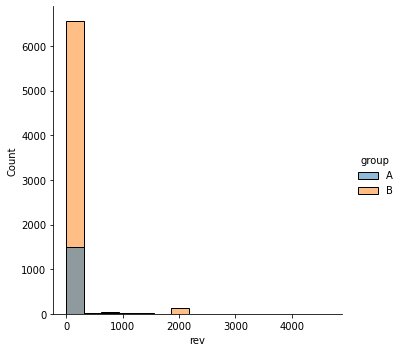

In [65]:
sns.displot(data=users_and_checks, x="rev", hue="group")

In [66]:
paid_users=users_and_checks.query('is_paid=="1"')

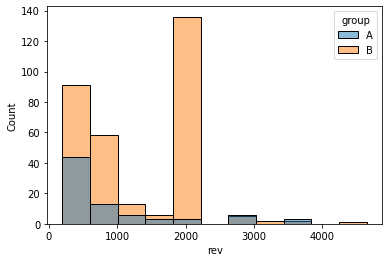

In [67]:
sns.histplot(data=paid_users, x="rev", hue="group", kde=False)

Посмотрим на распределение оплат(rev) по отдельности в зависимости от групп и от датафреймов(только оплатившие paid_users или все users_and_checks)

In [68]:
#Распределение по оплатившим по группам

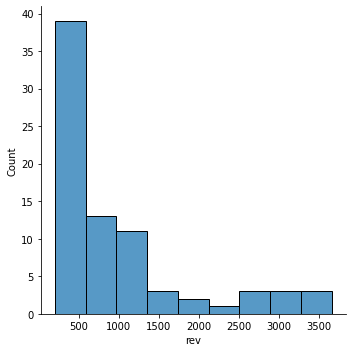

In [69]:
sns.displot(data=paid_users[paid_users.group=='A'], x='rev')

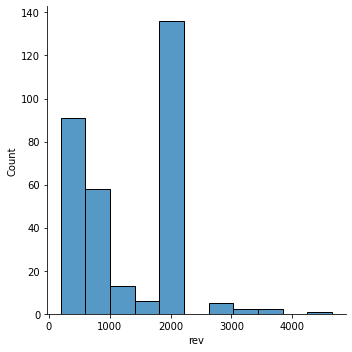

In [70]:
sns.displot(data=paid_users[paid_users.group=='B'], x='rev')

In [79]:
control_paid=paid_users.query('group=="A"')['rev']

In [91]:
testing_paid=paid_users.query('group=="B"')['rev']

In [92]:
#Проверим требование к гомогенности дисперсий

In [93]:
levene(control_paid,testing_paid)

LeveneResult(statistic=3.075681699981606, pvalue=0.08025675761347022)

In [90]:
paid_users[['rev','group']].groupby(['group']).describe()

rev                                                                 
       count         mean         std    min     25%     50%      75%     max
group                                                                        
A       78.0   933.589744  919.932711  199.0  290.00   585.0  1114.75  3660.0
B      314.0  1257.878992  790.864254  199.0  511.75  1140.0  1900.00  4650.0

Вывод по распределениям оплативших.

Таким образом, распределения среди оплативших клиентов в период A/B тестирования ненормальные, левосторонние, с выбросами 2500 до максимального 4650 в группе "B", в контрольной группе A, тоже есть выбросы, но чуть побольше (больше 2000 у.е. (не включая 2000 у.е. до максимального значения 3660 у.е.) Причинами могут быть разные: от некорректного сбора данных до формирования небольшого количества очень лояльных клиентов. В любом случае, для дальнейшего анализа их отрезать не надо, поскольку есть риск потери данных и искажений ARPU и ARPPU. Нулевая гипотеза о равенстве дисперсий генеральных совокупностей не опроверглась

In [ ]:
#Распределение по всем по группам

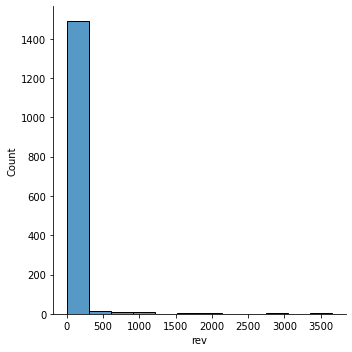

In [82]:
sns.displot(data=users_and_checks[users_and_checks.group=='A'], x='rev')

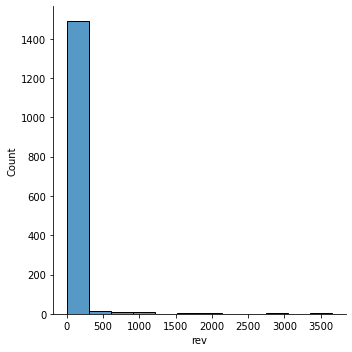

In [83]:
sns.displot(data=users_and_checks[users_and_checks.group=='A'], x='rev')

In [84]:
control_group_rev=control_group['rev']

In [85]:
testing_group_rev=testing_group['rev']

In [87]:
#Проверим требование к гомогенности дисперсий

In [86]:
levene(control_group_rev, testing_group_rev)

LeveneResult(statistic=1.501460829433639, pvalue=0.22048133327049665)

Таким образом, распределения среди всех пользователей в период A/B тестирования ненормальные, унимодальные, нулевая гипотеза о равенстве дисперсий генеральных совокупностей не опроверглась

Как мы видим, распределения ненормальные, поэтому стоит использовать непараметрические анализы.Тест Колмогорова - Смирнова подходит наиболее всего, однако более наглядным и интуитивно понятным для тех, кто будет смотреть этот отчет будет являться бустрап.

In [102]:
#Посчитаем наши метрики(ARPU и ARPPU)

In [103]:
stat_df = users_and_checks.groupby(['group'], as_index=False).agg(
    converted_users = ('rev', lambda x: x[x > 0].count()),
    all_users = ('student_id', lambda x: len(x)),
    revenue =  ('rev', lambda x: sum(x))
)

stat_df['arpu'] = stat_df['revenue']/stat_df['all_users']
stat_df['arppu'] = stat_df['revenue']/stat_df['converted_users']

stat_df

,group,converted_users,all_users,revenue,arpu,arppu
0,A,78.0,1538,72820.0000,47.347204,933.589744
1,B,314.0,6803,394974.0035,58.058798,1257.878992


In [104]:
control_group=users_and_checks.query('group=="A"')

In [105]:
testing_group=users_and_checks.query('group=="B"')

In [106]:
print('Длина контрольной группы:', len(control_group))
print('Длина тестовой группы:', len(testing_group))

Длина контрольной группы: 1538
Длина тестовой группы: 6803


Поскольку итераций очень много и может показаться, что код завис.Поскольку рекоммендованое количество итераций для бустрепа с целью относительно точного результата обычно требуется количество в диапазоне от 1000 до 10000.Целесообразным в данном случае является использование tqdm, поскольку последний показывает процесс выполнения кода

In [107]:
from tqdm import tqdm

In [110]:
iterations = 9000

bootstrap_df = pd.DataFrame()
arpu_p_values = []

for x in tqdm(range(iterations)):  
    iter_df = users_and_checks.sample(frac = 1, replace=True).groupby(['group'], as_index=False).agg(
        arpu = ('rev', lambda x: x.sum()/len(x)),
        arppu = ('rev', lambda x: x[x>0].sum()/len(x[x>0]))
    )
    
  
    control_iter_df = iter_df[iter_df['group'] == 'A'].reset_index()
    variant_iter_df = iter_df[iter_df['group'] == 'B'].reset_index()
    
    bootstrap_df = pd.concat([bootstrap_df, iter_df])

100%|██████████| 9000/9000 [02:46<00:00, 54.16it/s]


In [112]:
#Посмотрим на получившийся датафрейм

In [111]:
bootstrap_df.head()

,group,arpu,arppu
0,A,37.199351,784.753425
1,B,58.596825,1207.627285
0,A,48.260563,835.731707
1,B,58.355585,1266.078384
0,A,56.536358,963.045455


используем функцию pd.melt(), чтобы преобразовать данные в длинный формат. В качестве var_name в названии kpi, но в нашем соучае это столбец, который отражает название показателей arppu/arpu,что потом упростит построение графиков 

In [114]:
bootstrap_df_melt = pd.melt(bootstrap_df, id_vars = 'group', value_vars = ['arppu', 'arpu'], var_name = 'kpi')
bootstrap_df_melt.head()

,group,kpi,value
0,A,arppu,784.753425
1,B,arppu,1207.627285
2,A,arppu,835.731707
3,B,arppu,1266.078384
4,A,arppu,963.045455


In [117]:
#построим распределения по нашим показателям в зависимости от групп(A,B)

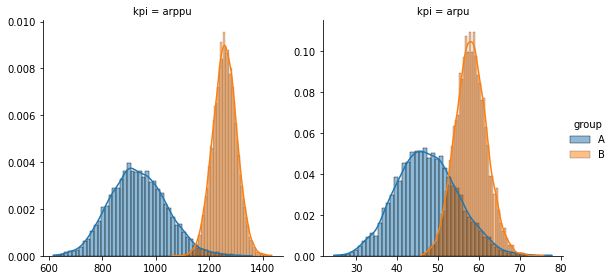

In [116]:
plot = sns.FacetGrid(bootstrap_df_melt, col="kpi", sharex = False, sharey = False, height = 4, hue = 'group')
plot.map_dataframe(sns.histplot, x="value", kde = True, stat = 'density', common_bins = True, fill = True)
plot.add_legend()

Лучше проверить, что данные для этих распределений не получены из одной и той же совокупности

In [118]:
bootstrap_control = bootstrap_df[bootstrap_df['group'] == 'A'].reset_index()
bootstrap_testing = bootstrap_df[bootstrap_df['group'] == 'B'].reset_index()

In [119]:
#Посчитаем разницу наших показателей разных групп

In [120]:
bootstrap_diffs = pd.DataFrame()

bootstrap_diffs['arpu_diff'] = bootstrap_testing['arpu'] - bootstrap_control['arpu']
bootstrap_diffs['arppu_diff'] = bootstrap_testing['arppu'] - bootstrap_control['arppu']

In [121]:
bootstrap_diffs_melt = pd.melt(bootstrap_diffs, value_vars = ['arpu_diff', 'arppu_diff'], var_name = 'kpi')

In [122]:
#построим графики для наших разниц

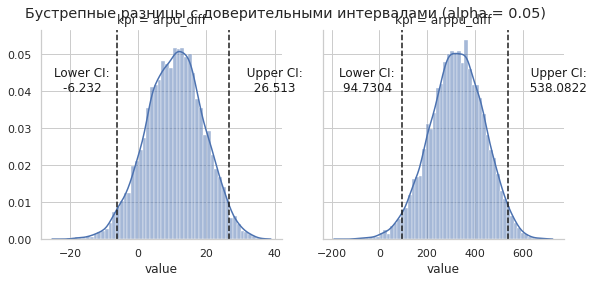

In [129]:
alpha = 0.05

lower_ci = alpha/2
upper_ci = 1 - (alpha/2)

plot = sns.FacetGrid(bootstrap_diffs_melt, col="kpi", sharex = False, sharey = True, height = 4)
plot.map_dataframe(sns.histplot, x="value", kde = True, stat = 'probability', common_bins = True, fill = True)
plot.fig.suptitle('Бустрепные разницы с доверительными интервалами (alpha = ' + str(alpha) + ')')

# Линии доверительных интервалов на графиках
plot = plot.map(lambda y, **kw: plt.axvline(y.quantile(lower_ci), color='k', linestyle='--'), 'value')
plot = plot.map(lambda y, **kw: plt.axvline(y.quantile(upper_ci), color='k', linestyle='--'), 'value')

# Примечания к доверительным интервалам
plot = plot.map(lambda y, **kw: plt.text(y.quantile(lower_ci),
                                         0.04,
                                         'Lower CI:' + ' ' * 18 + '\n' + str(round(y.quantile(lower_ci), 4)) + ' ' * 18,
                                         color='k',
                                         ha = 'center'),
                'value')
plot = plot.map(lambda y, **kw: plt.text(y.quantile(upper_ci)*1.125,
                                         0.04,
                                         ' ' * 18 + 'Upper CI:\n' + ' ' * 18 + str(round(y.quantile(upper_ci), 4)),
                                         color='k',
                                         ha = 'center'),
                'value')

plot.add_legend()

Поскольку ноль попадает в 95%-доверительный интервал ARPU, посчитаем вероятность что ARPU в тестовой группе будет хуже, чем ARPU в контрольной группе

In [130]:
arpu_prob = (bootstrap_diffs['arpu_diff'] < 0).mean()

print('Вероятность того, что ARPU в тестовой группе будет хуже, чем ARPU в контрольной группе, равна', '{:.2%}.'.format(arpu_prob))

Вероятность того, что ARPU в тестовой группе будет хуже, чем ARPU в контрольной группе, равна 10.37%.


### Итоги по 1 заданию
Таким образом, по 1 заданию я использовала следующие метрики:конверсия со входа на сайт в покупку, поскольку если бы она статистически значимо различалась с контрольной группой, это говорило бы о прямом влиянии новой механики оплаты услуг на сайте. Также я использовала ARPU(средний чек на пользователей в период тестирования) и ARPPU(средний чек среди уже оплативших клиентов), поскольку возможно новая система оплаты на сайте связана с выпадающими рекоммендациями в корзине+ если было неудобно покупать что-то на сайте, вероятно, клиент уже второй раз не вернулся бы и ушел к конкуренту.
Различия ARPU и ARPPU являются статистически значимыми(т.е. нулевые гипотезы 2, 3 опроверглись), больше всего новая механика оплаты услуг на сайте положительно влияет на средний чек среди что-то купивших клиентов сайта(ARPPU), чуть меньше на ARPU(средний чек среди пользователей), вероятность что последний при работе нового алгоритма будет хуже составляет (10.37%). Подводя итог, стоит запускать новую механику работы на всех пользователей, поскольку она увеличивает ARPU, ARPPU.

### Задание 2. SQL

2.1 Очень усердные ученики.

2.1.1 Условие
Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

2.1.2 Задача
Дана таблица default.peas.
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.

NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [134]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [135]:
first_variant_query='''
SELECT
    COUNT(DISTINCT st_id) as number_of_average_students, month
FROM
    (SELECT 
        st_id,
        SUM(correct) as sum_of_correct_answers,
        toStartOfMonth(timest) as month
    FROM 
        default.peas
    GROUP BY
        st_id, month
    HAVING
        SUM(correct) >= 20)
GROUP BY month
'''
task_2_1_2=ph.read_clickhouse(query=first_variant_query, connection=connection_default)
task_2_1_2

,number_of_average_students,month
0,136,2021-10-01


Ответ:количество очень усердных студентов составляет 136 человек

In [137]:
time_query='''
SELECT CAST(MAX(timest) as date) as max_t,
CAST(MIN(timest) as date) as min_t
FROM default.peas
'''
time_peas=ph.read_clickhouse(query=time_query, connection=connection_default)
time_peas

,max_t,min_t
0,2021-10-31,2021-10-30


Поскольку максимальная дата в таблице-2021 год, я использовала группировку по дате, чтобы узнать за текущий месяц проведения исследования,
если бы таблица дополнилась и/или эксперимент длился бы дольше, а в качестве текущего времени считалась бы дата написания ,
то запрос выглядел бы следующим образом:

In [31]:
another_variant_query='''
SELECT
    COUNT(DISTINCT st_id) as number_of_average_students
FROM
    (SELECT 
        st_id,
        SUM(correct) as sum_of_correct_answers,
        toStartOfMonth(timest) as month
    FROM 
        default.peas
    WHERE
        toStartOfMonth(timest) == toStartOfMonth(now())
    GROUP BY
        st_id, month
    HAVING
        SUM(correct) >= 20)
'''
task_2_1_2_another=ph.read_clickhouse(query=another_variant_query, connection=connection_default)

2.2 Оптимизация воронки

2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

2.2.2 Задача

Дана таблицы: default.peas (см. выше), default.studs:

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

1)ARPU 

2)ARPAU 

3)CR в покупку 

4)СR активного пользователя в покупку 

5)CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

Все данные находятся в табличном виде в ClickHouse

In [32]:
query_for_2_2_2_task='''
SELECT    
   test_grp,
   uniqExactIf(st_id, total_revenue > 0)/ uniqExact(st_id) as CR_to_buy,
   uniqExactIf(st_id,active_student=1 and total_revenue > 0)/uniqExactIf(st_id, active_student=1) as CR_to_buy_for_active_student,
   uniqExactIf(st_id, math_active_student=1 and total_revenue>0) / uniqExactIf(st_id, math_active_student=1) as CR_to_buy_for_math_student,
   sumIf(total_revenue,active_student=1)/uniqExactIf(st_id, active_student=1) as ARPAU,
   sumIf(total_revenue, math_active_student=1)/uniqExactIf(st_id, math_active_student=1) as ARPAU_for_math_active,
   sum(total_revenue)/uniqExact(st_id) as ARPU,
   sum(total_revenue)/uniqExactIf(st_id, total_revenue > 0) as ARPPU
   FROM
   (
       SELECT 
       D.st_id as st_id,
       D.test_grp as test_grp,
       C.active_student as active_student,
       C.math_active_student as math_active_student,
       C.math_rev as math_rev,
       C.total_revenue as total_revenue
       FROM
       (SELECT
       st_id,
       test_grp 
       FROM default.studs) as D
      LEFT JOIN 
        (SELECT
        B.st_id as st_id,
        B.active_student as active_student,
        B. math_active_student as math_active_student,
        A.math_rev as math_rev,
        A.total_revenue as total_revenue
        FROM
        (SELECT
        st_id,
        if (sum(correct)>10, 1,0) as active_student,
        if (sumIf(correct, subject='Math') >= 2, 1, 0) as math_active_student
        FROM default.peas
        GROUP BY st_id) as B
        LEFT JOIN 
            (SELECT 
            st_id,
            sumIf(money, subject='Math') as math_rev,
            sum(money) as total_revenue
            FROM default.final_project_check
            GROUP BY st_id) as A
        ON B.st_id=A.st_id)as C
    ON D.st_id=C.st_id
    ) 
    GROUP BY test_grp
'''
task_2_2_2=ph.read_clickhouse(query=query_for_2_2_2_task, connection=connection_default)
task_2_2_2

,test_grp,CR_to_buy,CR_to_buy_for_active_student,CR_to_buy_for_math_student,ARPAU,ARPAU_for_math_active,ARPU,ARPPU
0,control,0.049180,0.110236,0.102041,10393.700787,9591.836735,4540.983607,92333.333333
1,pilot,0.101695,0.260417,0.142857,29739.583333,19285.714286,11067.796610,108833.333333


### Выводы по заданию 2.2.2: 
    CR в покупку у относительно контрольной группы вырост в 2 раза, 
    CR в покупку среди активных студентов вырос в 2.36 раза,
    CR среди активных студентов по математике вырос на 41%, 
    ARPAU вырос в 2.86 раза,
    ARPAU для активных по математике 2.01 
    ARPU вырос в 2.4 раза
    ARPPU вырос на 20%
Таким образом, новый экран оплаты, разработанный командой, можно раскатывать на всех пользователей

### Задание 3. Python

### 3.1 Задача
Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

для того, чтобы сверять данные и пересчитывать метрики, захэшируем исходный файл add_group_copy, а затем будем сверять хэши файлов и при не совпадении, пересчитывать метрики....

In [ ]:
#импортируем часть необходимых библиотек

In [36]:
import sys
import hashlib as hl
import os
import requests as rq
from urllib.parse import urlencode
import matplotlib.pyplot as plt

В данном задании был использован другой файл groups_add_1 для проверки работы кода, так как изменений в изначальном файле не было. 
Алгоритм действий следующий:

1) загружаю csv-файл groups_add_1

2) удаляю все строки с 10 включительно

3)смотрю на изменение метрик и по ним пишу выводы

Для того, чтобы сохранить исходный csv-файл захешируем его и при несоответствии хэша изначального файла существующему выводим таблицу с изменением метрик и строим графики

In [37]:
def get_hash(df):
    return hl.sha256(df.to_json().encode()).hexdigest()

Для упрощения работы все предшествующие объединения датафреймов(которые были использованы в 1 задании для подсчета метрик) и сами метрики запишем в 1 датафрейм

In [38]:
def get_stats(groups_1, group_add_1, active_studs_1, checks_1):    
    full_group_1 = pd.concat([groups_1, group_add_1], ignore_index = True)
    stats = active_studs_1.merge(full_group_1, left_on = 'student_id', right_on = 'id', how = 'left')\
                        .drop('id', axis = 1).rename(columns = {'grp':'group'})\
                        .merge(checks_1, how = 'left', on = 'student_id')\
                        .groupby(['group','student_id']).agg({'rev':'sum'}).reset_index()\
                        .groupby(['group'], as_index = False)\
                        .agg(converted_users = ('rev', lambda x: x[x > 0].count()),\
                             all_users = ('student_id', lambda x: len(x)),\
                             revenue = ('rev', lambda x: sum(x)))
    
    stats['arpu'] = stats['revenue'] / stats['all_users']
    stats['arppu'] = stats['revenue'] / stats['converted_users']
    return stats

In [39]:
try:
    groups_1 =         pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-chudnaja/Проект_2_groups.csv', sep = ';')
    group_add_1 =      pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-chudnaja/project_2_group_add.csv')
    active_studs_1 =   pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-chudnaja/Проект_2_active_studs.csv')
    checks_1 =         pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-chudnaja/Проект_2_checks.csv', sep = ';')

except Exception as ex: # обработка исключения 
    print(ex) 
    os._exit(1) # остановка программы

  group  converted_users  all_users      revenue       arpu        arppu  \
0     A             78.0       1535   72820.0000  47.439739   933.589744   
1     B            313.0       6794  393074.0035  57.856050  1255.827487   

  version  
0     new  
1     new  
  group  converted_users  all_users      revenue  conversion       arpu  \
0     A             78.0       1538   72820.0000    0.050715  47.347204   
1     B            314.0       6803  394974.0035    0.046156  58.058798   

         arppu version  
0   933.589744     old  
1  1257.878992     old  


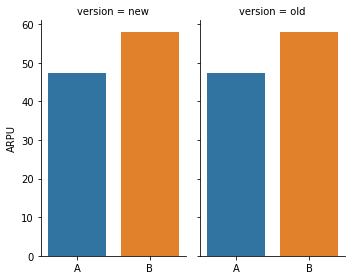

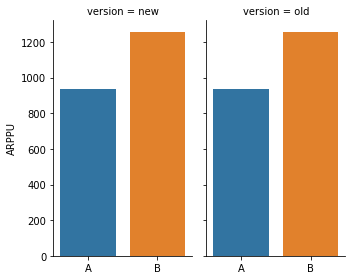

In [40]:
filemode = "r+" if os.path.isfile("checksum.txt") else "w+" # R+ чтение + запись (не создает файл при отсутствии), W+ чтение + запись поверх (создает файл)
hash_fact = get_hash(group_add_1)
    
with open("checksum.txt", filemode) as file_cs:
    hash_prev = file_cs.read()
    if (hash_fact != hash_prev):        
        
        stats = get_stats(groups_1, group_add_1, active_studs_1, checks_1)
        stats['version']='new'
        
        if os.path.isfile("stats_old.csv") == True:
            stats_old = pd.read_csv("stats_old.csv", sep = ';')
        else:
            stats_old = stats.copy()
            
        stats_old['version']='old'
        
        print(stats)
        print(stats_old)
        
        stats_total=pd.concat([stats, stats_old])
        
        
        # отрисовка графиков
        g = sns.catplot(
                data=stats_total, x="group", y="arpu", col="version",
                kind="bar", height=4, aspect=.6,
                    )
        g.set_axis_labels("", "ARPU")
        plt.show()
       
        k = sns.catplot(
                data=stats_total, x="group", y="arppu", col="version",
                kind="bar", height=4, aspect=.6,
                    )
        k.set_axis_labels("", "ARPPU")
        plt.show()
        
        stats.to_csv("stats_old.csv", sep = ';', index = False) # обновление метрик
        
        file_cs.seek(0) # обновление хэша
        file_cs.write(hash_fact)
        file_cs.truncate()
        
    file_cs.close()

Исходя из данных графиков, при удалении примерно 90% данных из groups_add_1 изменяются, но на очень маленькое значение.Так происходит из-за джойнов(поскольку не все юзеры были активными в день эксперимента и имели данные по оплате или не оплате услуг на сайте)